In [1]:
!pip install transformers datasets evaluate torch scikit-learn matplotlib seaborn streamlit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.0 MB/s eta 0:00:0000:0100:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 14.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
from sklearn.metrics import confusion_matrix, classification_report

2025-11-25 04:01:25.724055: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764043285.913960      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764043285.970344      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
print("Loading dataset...")
# Using IMDb dataset (Sentiment Analysis: 0 = Negative, 1 = Positive)
dataset = load_dataset("imdb")

# Text Cleaning Function (Lowercasing)
def clean_text(examples):
    examples['text'] = [t.lower() for t in examples['text']]
    return examples

dataset = dataset.map(clean_text, batched=True)

Loading dataset...


README.md: 0.00B [00:00, ?B/s]

plain_text/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

plain_text/test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

plain_text/unsupervised-00000-of-00001.p(…):   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [4]:
# Tokenization
model_checkpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [5]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=256)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [6]:
# Creating the 80/10/10 Split
# Combining distinct datasets for reshuffling
full_dataset = tokenized_datasets["train"].train_test_split(test_size=0.2, seed=42)
train_dataset = full_dataset["train"] # 80%

# Splitting the remaining 20% into Validation (10%) and Test (10%)
test_val_split = full_dataset["test"].train_test_split(test_size=0.5, seed=42)
eval_dataset = test_val_split["train"] # 10% (Validation)
test_dataset = test_val_split["test"]  # 10% (Test)

print(f"Train Size: {len(train_dataset)}, Val Size: {len(eval_dataset)}, Test Size: {len(test_dataset)}")

Train Size: 20000, Val Size: 2500, Test Size: 2500


In [7]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [8]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_checkpoint,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [9]:
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")
precision_metric = evaluate.load("precision")
recall_metric = evaluate.load("recall")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    acc = accuracy_metric.compute(predictions=predictions, references=labels)
    f1 = f1_metric.compute(predictions=predictions, references=labels)
    prec = precision_metric.compute(predictions=predictions, references=labels)
    rec = recall_metric.compute(predictions=predictions, references=labels)

    return {
        "accuracy": acc["accuracy"],
        "precision": prec["precision"],
        "recall": rec["recall"],
        "f1": f1["f1"]
    }

In [10]:
# Training Arguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none"
)

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

print("Starting Training...")
trainer.train()

/tmp/ipykernel_47/779350273.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Starting Training...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.320600,0.237728,0.905200,0.878766,0.943218,0.909852
2,0.197300,0.242606,0.913600,0.918790,0.910095,0.914422
3,0.141500,0.309002,0.907600,0.922575,0.892744,0.907415
4,0.071400,0.382009,0.903200,0.912379,0.895110,0.903662
5,0.042700,0.412025,0.904800,0.918699,0.891167,0.904724


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=3125, training_loss=0.14144394653320314, metrics={'train_runtime': 1406.1689, 'train_samples_per_second': 71.115, 'train_steps_per_second': 2.222, 'total_flos': 6623369932800000.0, 'train_loss': 0.14144394653320314, 'epoch': 5.0})

In [12]:
print("Evaluating on Test Set...")
test_results = trainer.predict(test_dataset)
print("Test Metrics:", test_results.metrics)

Evaluating on Test Set...


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Test Metrics: {'test_loss': 0.2531208097934723, 'test_accuracy': 0.8932, 'test_precision': 0.8664150943396226, 'test_recall': 0.9273021001615509, 'test_f1': 0.8958252048380805, 'test_runtime': 11.2464, 'test_samples_per_second': 222.293, 'test_steps_per_second': 7.024}


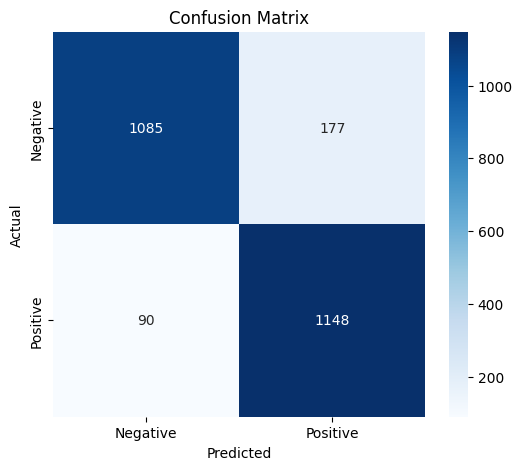

In [13]:
# Confusion Matrix
y_true = test_results.label_ids
y_pred = np.argmax(test_results.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [14]:
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=['Negative', 'Positive']))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.92      0.86      0.89      1262
    Positive       0.87      0.93      0.90      1238

    accuracy                           0.89      2500
   macro avg       0.89      0.89      0.89      2500
weighted avg       0.90      0.89      0.89      2500



In [15]:
# Save the model
model.save_pretrained("./my_finetuned_model")
tokenizer.save_pretrained("./my_finetuned_model")
print("Model saved successfully!")

Model saved successfully!


## **Streamlit UI**

In [20]:
# app.py
import streamlit as st
from transformers import pipeline

# Title
st.title("📝 Sentiment Analysis App")
st.subheader("Project 1: Fine-Tuned DistilBERT")

model_path = "./my_finetuned_model"

try:
    classifier = pipeline("text-classification", model=model_path)
    st.success("Model loaded successfully!")
except Exception as e:
    st.error(f"Error loading model. Make sure '{model_path}' exists. Error: {e}")

# User Input
user_input = st.text_area("Enter text to analyze:", "This movie was absolutely fantastic!")

if st.button("Analyze"):
    if user_input:
        result = classifier(user_input)
        label = result[0]['label']
        score = result[0]['score']

        # Display Result
        if label == "POSITIVE":
            st.markdown(f"### Prediction: **:green[{label}]**")
        else:
            st.markdown(f"### Prediction: **:red[{label}]**")

        st.write(f"Confidence Score: {score:.4f}")
    else:
        st.warning("Please enter some text.")

2025-11-25 05:02:42.819 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:02:42.821 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:02:42.822 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:02:42.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:02:42.823 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:02:42.824 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
Device set to use cuda:0
2025-11-25 05:02:42.986 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:02:42.987 Thread 'MainThread': missing ScriptRunContext! This warning can be ig

In [21]:
%%writefile app.py
import streamlit as st
from transformers import pipeline

# Load the model (Ensure this path matches where your model is saved)
# If you saved it in the previous step, it's likely "./my_finetuned_model"
model_path = "./my_finetuned_model" 

st.title("📝 Sentiment Analysis App")
st.subheader("Project 1: Fine-Tuned DistilBERT")

try:
    # Load pipeline
    classifier = pipeline("text-classification", model=model_path)
    
    # Text Input
    user_input = st.text_area("Enter text to analyze:", "This movie was absolutely fantastic!")

    if st.button("Analyze"):
        if user_input:
            result = classifier(user_input)
            label = result[0]['label']
            score = result[0]['score']
            
            if label == "POSITIVE":
                st.markdown(f"### Prediction: **:green[{label}]**")
            else:
                st.markdown(f"### Prediction: **:red[{label}]**")
            st.write(f"Confidence Score: {score:.4f}")
        else:
            st.warning("Please enter some text.")
            
except Exception as e:
    st.error(f"Could not load model. Error: {e}")

Writing app.py


In [24]:
# 1. Install pyngrok
!pip install pyngrok

# 2. Setup Ngrok (Replace 'YOUR_AUTHTOKEN_HERE' with your actual token)
from pyngrok import ngrok
import os

# Kill any existing tunnels to avoid errors
ngrok.kill()

# Set your token
ngrok.set_auth_token("2wRRbVVp5Pu0pru3y3W7YrI5PpY_JKtiuvrcCtF4eyjmiPr1")

# 3. Run Streamlit in the background
# app.py
import streamlit as st
from transformers import pipeline

# Title
st.title("📝 Sentiment Analysis App")
st.subheader("Project 1: Fine-Tuned DistilBERT")

model_path = "./my_finetuned_model"

try:
    classifier = pipeline("text-classification", model=model_path)
    st.success("Model loaded successfully!")
except Exception as e:
    st.error(f"Error loading model. Make sure '{model_path}' exists. Error: {e}")

# User Input
user_input = st.text_area("Enter text to analyze:", "This movie was absolutely fantastic!")

if st.button("Analyze"):
    if user_input:
        result = classifier(user_input)
        label = result[0]['label']
        score = result[0]['score']

        # Display Result
        if label == "POSITIVE":
            st.markdown(f"### Prediction: **:green[{label}]**")
        else:
            st.markdown(f"### Prediction: **:red[{label}]**")

        st.write(f"Confidence Score: {score:.4f}")
    else:
        st.warning("Please enter some text.")

import subprocess
# Start Streamlit in the background
subprocess.Popen(["streamlit", "run", "app.py"])

# 4. Open the Tunnel
public_url = ngrok.connect(8501)
print(f"🚀 Your App is running at: {public_url}")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2025-11-25 05:17:14.650 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:17:14.651 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:17:14.652 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:17:14.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:17:14.653 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:17:14.654 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
Device set to use cuda:0
2025-11-25 05:17:14.826 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-11-25 05:17:14.827 Thread 'MainThread': missing ScriptRunContext! This warning can be ig

🚀 Your App is running at: NgrokTunnel: "https://2b064cd0b4a9.ngrok-free.app" -> "http://localhost:8501"



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8502
  Network URL: http://172.19.2.2:8502
  External URL: http://34.41.103.142:8502



2025-11-25 05:17:33.869966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764047853.897848    7493 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764047853.905905    7493 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
Device set to use cuda:0
Device set to use cuda:0
Device set to use cuda:0
De